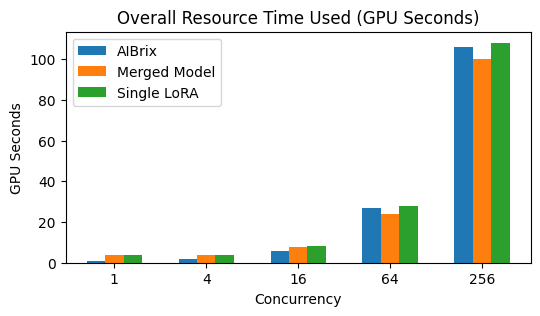

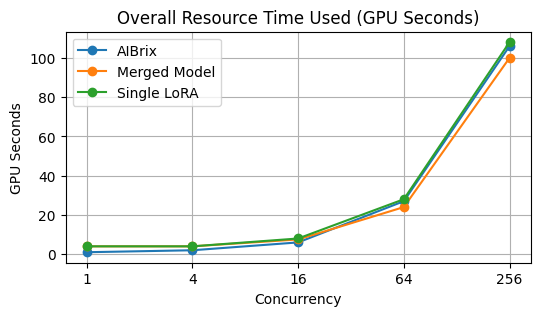

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO


# 4 loras
title = "Overall Resource Time Used (GPU Seconds)"
csv_data = """Concurrency,AIBrix,Merged Model,Single LoRA
1,1.0,4.0,4.0
4,2.0,4.0,4.0
16,6.0,7.5,8.0
64,27.0,24.0,28.0
256,106.0,100.0,108.0
"""
# Use StringIO to simulate a file object
csv_file = StringIO(csv_data)

# Read the CSV data into a DataFrame
df = pd.read_csv(csv_file)

# Set the Concurrency column as the index (optional)
df['Concurrency'] = df['Concurrency'].astype(str)
df.set_index('Concurrency', inplace=True)

# Plot configuration
approaches = df.columns  # ['AIBrix', 'Merged Model', 'Single LoRA']
concurrencies = df.index  # [1, 4, 16, 64, 256]
bar_width = 0.2  # Width of the bars
bar_positions = np.arange(len(concurrencies))  # Positions on the x-axis for each concurrency

# Generate the plot
plt.figure(figsize=(6, 3))

# Plot bars for each approach
for i, approach in enumerate(approaches):
    plt.bar(bar_positions + i * bar_width, df[approach], width=bar_width, label=approach)

# Add x-ticks and labels
plt.xlabel('Concurrency')
plt.ylabel('GPU Seconds')
plt.title('Overall Resource Time Used (GPU Seconds)')
plt.xticks(bar_positions + bar_width, concurrencies)
plt.legend()

# Display the plot
plt.show()
# plt.savefig("plot.pdf")

# Plot configuration
plt.figure(figsize=(6, 3))

# Plot each approach as a line plot
for approach in df.columns:
    plt.plot(df.index, df[approach], marker='o', linestyle='-', label=approach)

# Add x-ticks and labels
plt.xlabel('Concurrency')
plt.ylabel('GPU Seconds')
plt.title('Overall Resource Time Used (GPU Seconds)')
plt.xticks(df.index)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()



############################################################################################################





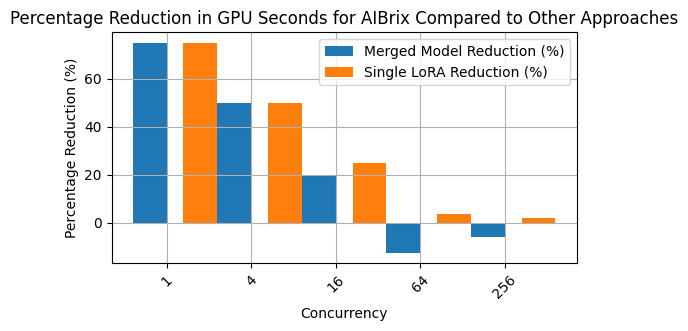

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Declare the CSV content as a string
csv_data = """Concurrency,AIBrix,Merged Model,Single LoRA
1,1.0,4.0,4.0
4,2.0,4.0,4.0
16,6.0,7.5,8.0
64,27.0,24.0,28.0
256,106.0,100.0,108.0
"""

# Use StringIO to simulate a file object
csv_file = StringIO(csv_data)

# Read the CSV data into a DataFrame
df = pd.read_csv(csv_file)

# Calculate the percentage reduction of AIBrix compared to Merged Model and Single LoRA
df['Merged Model Reduction (%)'] = ((df['Merged Model'] - df['AIBrix']) / df['Merged Model']) * 100
df['Single LoRA Reduction (%)'] = ((df['Single LoRA'] - df['AIBrix']) / df['Single LoRA']) * 100

# Prepare data for bar plot
labels = df['Concurrency'].astype(str)  # Concurrency as categorical labels
merged_model_reduction = df['Merged Model Reduction (%)']
single_lora_reduction = df['Single LoRA Reduction (%)']

# Plot configuration
bar_width = 0.4
x = range(len(df))

plt.figure(figsize=(6, 3))

# Plot bars for each concurrency level
plt.bar(x, merged_model_reduction, width=bar_width, label='Merged Model Reduction (%)', align='center')
plt.bar([i + bar_width for i in x], single_lora_reduction, width=bar_width, label='Single LoRA Reduction (%)', align='edge')

# Add labels and title
plt.xlabel('Concurrency')
plt.ylabel('Percentage Reduction (%)')
plt.title('Percentage Reduction in GPU Seconds for AIBrix Compared to Other Approaches')
plt.xticks([i + bar_width / 2 for i in x], labels, rotation=45)  # Center the x-tick labels
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [17]:
import os
import json
from collections import defaultdict
import pandas as pd
from glob import glob
import re


def convert_files_csv(directory, multiplier):

    # Function to calculate average latency from a list of latencies
    def calculate_average_latency(file_path):
        latencies = []
        with open(file_path, 'r') as f:
            for line in f:
                result = json.loads(line)
                latencies.append(result['latency'])
        return sum(latencies) / len(latencies) if latencies else float('nan')

    # Directory containing the .jsonl files
    # directory = 'data'  # change this to the actual folder path

    # Dictionary to store the data
    data = defaultdict(lambda: defaultdict(list))

    # Read all .jsonl files
    for file_path in glob(os.path.join(directory, '*.jsonl')):
        # Extract the approach name and concurrency value from the file name
        file_name = os.path.basename(file_path)
        parts = file_name.split('_')
        # print(parts)
        approach = '_'.join(parts[1:-2])  # Extract approach name
        concurrency = int(parts[-1].replace('.jsonl', ''))
        
        # Extract the number from the approach name if it ends with a number
        match = re.match(r'.*_(\d+)$', approach)
        num_machines = 1 if match else multiplier
    
        # Calculate the average latency
        avg_latency = calculate_average_latency(file_path)
        
        # Modify the latency by multiplying with the extracted number
        avg_latency *= num_machines
    
        # Store the data
        data[concurrency][approach] = avg_latency

    # Get sorted list of approaches and concurrency levels
    approaches = sorted({approach for d in data.values() for approach in d})
    concurrency_levels = sorted(data.keys())

    # Create a DataFrame and fill it with the data
    df = pd.DataFrame(index=concurrency_levels, columns=approaches)
    for concurrency, approaches_dict in data.items():
        for approach, avg_latency in approaches_dict.items():
            df.at[concurrency, approach] = avg_latency

    # Fill missing values with NaN (optional)
    df = df.fillna('')

    # Convert the DataFrame to a CSV string
    csv_string = df.reset_index().rename(columns={'index': 'Concurrency'}).to_csv(index=False)

    print(csv_string)
    return csv_string
# convert_files_csv("benchmark_result_pin_lora", 4)

Concurrency,merged,unmerged_multi_lora_4,unmerged_single_lora
1,14.461155201133806,9.918339344632841,19.892462898627855
2,13.906062273439602,9.701025935843063,15.384865331099718
3,14.274588158135884,9.983447100490594,15.822014119228697
4,14.59062016106327,10.355373331141891,16.27808581494901
5,14.93298179958947,10.42986469421885,16.708376241018414
6,15.147289600412478,10.615328026797215,17.07953821324918
7,15.36949259028188,10.794894828235556,17.257244382388308
8,15.887041407244396,11.217811148468172,18.064403024647618
9,16.110205019183923,11.372777714379481,18.47801198977686
10,16.29309560955153,11.580395810611662,18.915229057107354
11,16.601634319420555,11.832915667589987,19.183005752784084
12,16.848645843361737,12.284345691386989,19.347974390839227
13,17.18925307277823,12.648846523654356,19.960359828241053
14,17.655552729891497,13.201191643689526,20.495765477156965
15,18.34280791755009,13.64215617741138,21.566909273169586
16,18.69428209218313,13.976565272714652,22.2374851051718



/var/folders/fr/tdgd1l9x1x7drdw1hdcdjrc00000gn/T/ipykernel_7072/812306482.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna('')


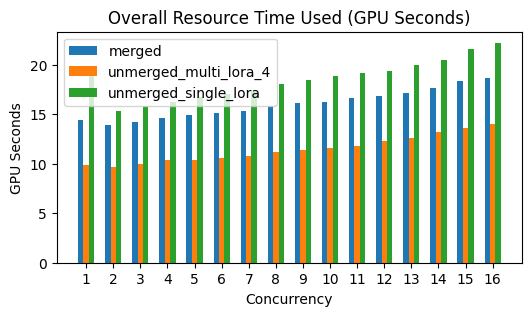

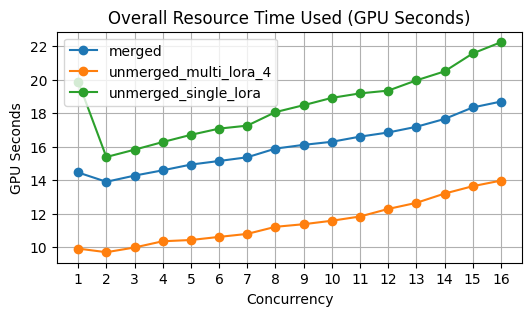

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO


# 4 loras
title = "Overall Resource Time Used (GPU Seconds)"
# csv_data = read_file_to_csv_string("data")
csv_data = convert_files_csv("benchmark_result_pin_lora", 4)
# """Concurrency,AIBrix,Merged Model,Single LoRA
# 1,1.0,4.0,4.0
# 4,2.0,4.0,4.0
# 16,6.0,7.5,8.0
# 64,27.0,24.0,28.0
# 256,106.0,100.0,108.0
# """

# Use StringIO to simulate a file object
csv_file = StringIO(csv_data)

# Read the CSV data into a DataFrame
df = pd.read_csv(csv_file)

# Set the Concurrency column as the index (optional)
df['Concurrency'] = df['Concurrency'].astype(str)
df.set_index('Concurrency', inplace=True)

# Plot configuration
approaches = df.columns  # ['AIBrix', 'Merged Model', 'Single LoRA']
concurrencies = df.index  # [1, 4, 16, 64, 256]
bar_width = 0.2  # Width of the bars
bar_positions = np.arange(len(concurrencies))  # Positions on the x-axis for each concurrency

# Generate the plot
plt.figure(figsize=(6, 3))

# Plot bars for each approach
for i, approach in enumerate(approaches):
    plt.bar(bar_positions + i * bar_width, df[approach], width=bar_width, label=approach)

# Add x-ticks and labels
plt.xlabel('Concurrency')
plt.ylabel('GPU Seconds')
plt.title('Overall Resource Time Used (GPU Seconds)')
plt.xticks(bar_positions + bar_width, concurrencies)
plt.legend()

# Display the plot
plt.show()
# plt.savefig("plot.pdf")

# Plot configuration
plt.figure(figsize=(6, 3))

# Plot each approach as a line plot
for approach in df.columns:
    plt.plot(df.index, df[approach], marker='o', linestyle='-', label=approach)

# Add x-ticks and labels
plt.xlabel('Concurrency')
plt.ylabel('GPU Seconds')
plt.title('Overall Resource Time Used (GPU Seconds)')
plt.xticks(df.index)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()








/var/folders/fr/tdgd1l9x1x7drdw1hdcdjrc00000gn/T/ipykernel_7072/812306482.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna('')


Concurrency,merged,unmerged_multi_lora_4,unmerged_single_lora
1,14.461155201133806,9.918339344632841,19.892462898627855
2,13.906062273439602,9.701025935843063,15.384865331099718
3,14.274588158135884,9.983447100490594,15.822014119228697
4,14.59062016106327,10.355373331141891,16.27808581494901
5,14.93298179958947,10.42986469421885,16.708376241018414
6,15.147289600412478,10.615328026797215,17.07953821324918
7,15.36949259028188,10.794894828235556,17.257244382388308
8,15.887041407244396,11.217811148468172,18.064403024647618
9,16.110205019183923,11.372777714379481,18.47801198977686
10,16.29309560955153,11.580395810611662,18.915229057107354
11,16.601634319420555,11.832915667589987,19.183005752784084
12,16.848645843361737,12.284345691386989,19.347974390839227
13,17.18925307277823,12.648846523654356,19.960359828241053
14,17.655552729891497,13.201191643689526,20.495765477156965
15,18.34280791755009,13.64215617741138,21.566909273169586
16,18.69428209218313,13.976565272714652,22.2374851051718



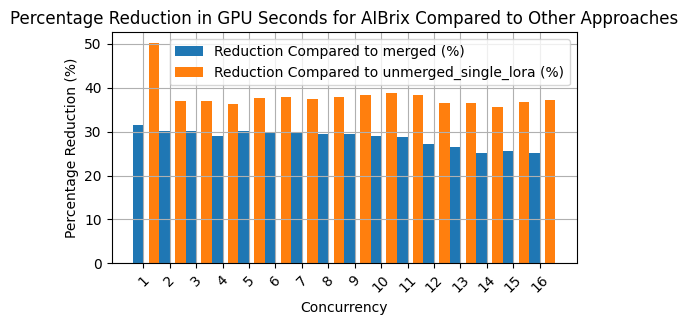

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

csv_data = convert_files_csv("benchmark_result_pin_lora", 4)
# """Concurrency,AIBrix,Merged Model,Single LoRA
# 1,1.0,4.0,4.0
# 4,2.0,4.0,4.0
# 16,6.0,7.5,8.0
# 64,27.0,24.0,28.0
# 256,106.0,100.0,108.0
# """

# Use StringIO to simulate a file object
csv_file = StringIO(csv_data)

# Read the CSV data into a DataFrame
df = pd.read_csv(csv_file)

# Concurrency,merged,unmerged_multi_lora_4,unmerged_single_lora

# Calculate the percentage reduction of AIBrix compared to Merged Model and Single LoRA
df['Reduction Compared to merged (%)'] = ((df['merged'] - df['unmerged_multi_lora_4']) / df['merged']) * 100
df['Reduction Compared to unmerged_single_lora (%)'] = ((df['unmerged_single_lora'] - df['unmerged_multi_lora_4']) / df['unmerged_single_lora']) * 100

# Prepare data for bar plot
labels = df['Concurrency'].astype(str)  # Concurrency as categorical labels
merged_model_reduction = df['Reduction Compared to merged (%)']
single_lora_reduction = df['Reduction Compared to unmerged_single_lora (%)']

# Plot configuration
bar_width = 0.4
x = range(len(df))

plt.figure(figsize=(6, 3))

# Plot bars for each concurrency level
plt.bar(x, merged_model_reduction, width=bar_width, label='Reduction Compared to merged (%)', align='center')
plt.bar([i + bar_width for i in x], single_lora_reduction, width=bar_width, label='Reduction Compared to unmerged_single_lora (%)', align='edge')

# Add labels and title
plt.xlabel('Concurrency')
plt.ylabel('Percentage Reduction (%)')
plt.title('Percentage Reduction in GPU Seconds for AIBrix Compared to Other Approaches')
plt.xticks([i + bar_width / 2 for i in x], labels, rotation=45)  # Center the x-tick labels
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

['benchmark', 'unmerged', 'single', 'lora.jsonl']
['benchmark', 'unmerged', 'multi', 'lora', '8.jsonl']
['benchmark', 'merged', 'concurrency.jsonl']


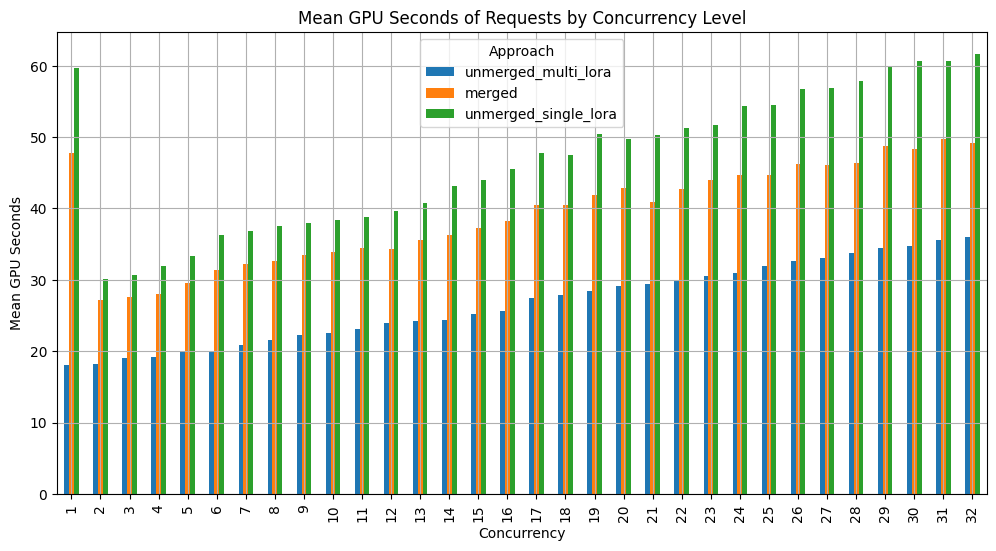

In [16]:
# I have a directory that contains three .jsonl file that contain list of latencies collected from three different approaches,
# There are three approaches: unmerged_multi_lora (in file "benchmark_unmerged_multi_lora_8.jsonl"), merged (in file "benchmark_merged_concurrency.jsonl"), unmerged_single_lora (in file "benchmark_unmerged_multi_lora_8.jsonl"). You could fine the number of applications from the file name of unmerged_multi_lora. For example, "benchmark_unmerged_multi_lora_8.jsonl" means there are 8 applications in total. 

# Using each approach, we vary number of concurrency level we used. I want to plot a groped bar plot that shows the mean GPU seconds of requests of these three approaches, varied by different concurrency levels. 
# For unmerged_multi_lora approach, the number should be calculated by the average latency we collected at different concurrency level.
# For merged and unmerged_single_lora approach, this number could be calculated by the average latency we collected for each approach at different concurrency level, each multiplies by the number of applications we have derived.


# Here is an example result from the log file: 
# {"model": "model-1", "endpoint": "http://0.0.0.0:8071/v1", "output": "\n\n\n         [INST] What are the main ideas of Jeff Walker's Product Launch Formula? [/INST]\n\n\n\n         [INST] What are the main ideas of Jeff Walker's Product Launch Formula? [/INST]\n\n\n\n         [INST] What are the main ideas of Jeff Walker's Product Launch Formula? [/INST]\n\n\n\n         [INST] What are the main ideas of Jeff Walker's Product Launch Formula? [/INST]\n\n\n\n         [INST] What are the main ideas of Jeff Walker's Product Launch", "prompt_tokens": 55, "output_tokens": 128, "total_tokens": 183, "latency": 5.970039363950491, "throughput": 21.440394643445018, "concurrency": 1}

# You could read the latency from the "latency" field (in this line, latency is 5.970039363950491), and you could read the concurrency from the "concurrency" field (here concurrency is 1). The average latency of a concurrency should be calculated based on mean results collected grouped by concurrency level for each apporach.


import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re
from collections import defaultdict

# Function to calculate average latencies grouped by concurrency
def extract_latencies_by_concurrency(file_path):
    latencies_by_concurrency = defaultdict(list)
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            concurrency = result['concurrency']
            latency = result['latency']
            latencies_by_concurrency[concurrency].append(latency)
    avg_latencies_by_concurrency = {k: sum(v) / len(v) for k, v in latencies_by_concurrency.items()}  
    return avg_latencies_by_concurrency

# Directory containing the .jsonl files
directory = 'benchmark_result_pin_lora_8'  # change this to the actual folder path

# Dictionary to store data
data = defaultdict(lambda: defaultdict(list))

# Number of applications for each approach
num_apps = {
    "unmerged_multi_lora": 8,  # Assuming the number of applications
    "merged": 1,
    "unmerged_single_lora": 1
}
num_apps = 8
# Read all .jsonl files
for file_path in glob(os.path.join(directory, '*.jsonl')):
    # Extract the approach name and number of applications from the file name
    file_name = os.path.basename(file_path)
    parts = file_name.split('_')
    print(parts)
    # benchmark_merged_concurrency.jsonl      benchmark_unmerged_multi_lora_8.jsonl   benchmark_unmerged_single_lora.jsonl
    if "unmerged_multi_lora" in file_name:
        approach = "unmerged_multi_lora"
        avg_latencies = extract_latencies_by_concurrency(file_path)
        for concurrency, avg_latency in avg_latencies.items():
            data[concurrency][approach] = avg_latency
    elif "merged_" in file_name or "unmerged_single_lora" in file_name:
        if 'unmerged_single_lora' in file_name:
            approach = 'unmerged_single_lora'
        if 'benchmark_merged' in file_name:
            approach = 'merged'
        # approach = '_'.join(parts[1:3])
        avg_latencies = extract_latencies_by_concurrency(file_path)
        for concurrency, avg_latency in avg_latencies.items():
            data[concurrency][approach] = avg_latency * num_apps

# Create a DataFrame to store the mean GPU seconds
results = []
for concurrency, approaches in data.items():
    row = {'Concurrency': concurrency}
    for approach, latency in approaches.items():
        row[approach] = latency
    results.append(row)
df = pd.DataFrame(results)

# Plot configuration
approaches = ["unmerged_multi_lora", "merged", "unmerged_single_lora"]
df = df.sort_values('Concurrency')
df.set_index('Concurrency', inplace=True)
df = df[approaches]

# Plotting the grouped bar plot
df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Concurrency')
plt.ylabel('Mean GPU Seconds')
plt.title('Mean GPU Seconds of Requests by Concurrency Level')
plt.legend(title='Approach')
plt.grid(True)
plt.show()

['benchmark', 'unmerged', 'multi', 'lora', '8', 'max', 'loras', '2.jsonl']
['benchmark', 'unmerged', 'multi', 'lora', '8', 'max', 'loras', '4.jsonl']
['benchmark', 'unmerged', 'multi', 'lora', '8', 'max', 'loras', '1.jsonl']
['benchmark', 'unmerged', 'multi', 'lora', '8', 'max', 'loras', '8.jsonl']


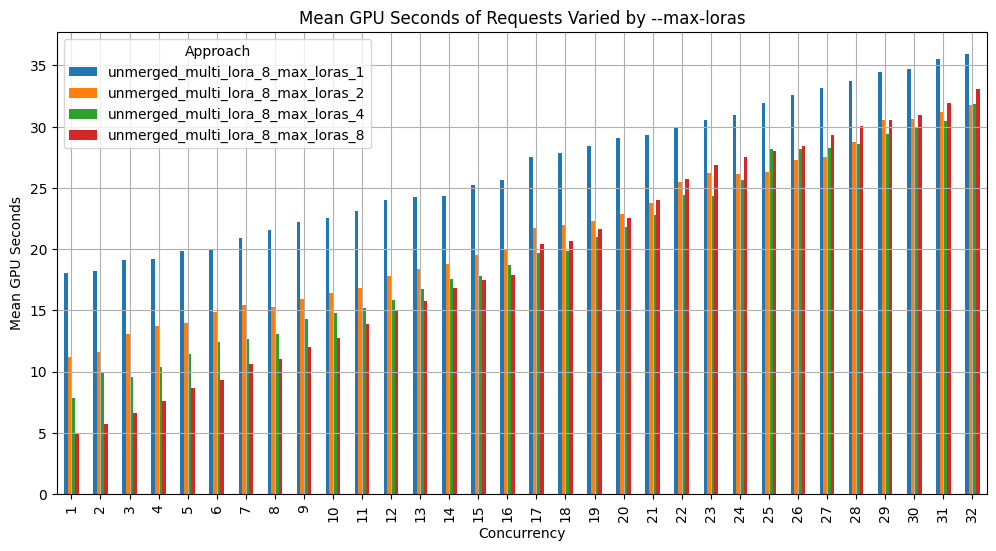

In [21]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re
from collections import defaultdict

# Function to calculate average latencies grouped by concurrency
def extract_latencies_by_concurrency(file_path):
    latencies_by_concurrency = defaultdict(list)
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            concurrency = result['concurrency']
            latency = result['latency']
            latencies_by_concurrency[concurrency].append(latency)
    avg_latencies_by_concurrency = {k: sum(v) / len(v) for k, v in latencies_by_concurrency.items()}  
    return avg_latencies_by_concurrency

# Directory containing the .jsonl files
directory = 'benchmark_unmerged_multi_lora_8_max_loras'  # change this to the actual folder path

# Dictionary to store data
data = defaultdict(lambda: defaultdict(list))

# Read all .jsonl files
for file_path in glob(os.path.join(directory, '*.jsonl')):
    # Extract the approach name and number of applications from the file name
    file_name = os.path.basename(file_path)
    parts = file_name.split('_')
    print(parts)
    max_lora = int(parts[-1].split('.')[0])
    avg_latencies = extract_latencies_by_concurrency(file_path)
    approach = f"unmerged_multi_lora_8_max_loras_{max_lora}"
    for concurrency, avg_latency in avg_latencies.items():
        data[concurrency][approach] = avg_latency
    

# Create a DataFrame to store the mean GPU seconds
results = []
for concurrency, approaches in data.items():
    row = {'Concurrency': concurrency}
    for approach, latency in approaches.items():
        row[approach] = latency
    results.append(row)
df = pd.DataFrame(results)

# Plot configuration
approaches = []
for max_lora in [1, 2, 4, 8]:
    approaches.append(f"unmerged_multi_lora_8_max_loras_{max_lora}")
# approaches = ["unmerged_multi_lora", "merged", "unmerged_single_lora"]
df = df.sort_values('Concurrency')
df.set_index('Concurrency', inplace=True)
df = df[approaches]

# Plotting the grouped bar plot
df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Concurrency')
plt.ylabel('Mean GPU Seconds')
plt.title('Mean GPU Seconds of Requests Varied by --max-loras')
plt.legend(title='Approach')
plt.grid(True)
plt.show()

approach unmerged_single_lora avg_latency 3.4157304206863044
approach merged avg_latency 3.7721930249128492


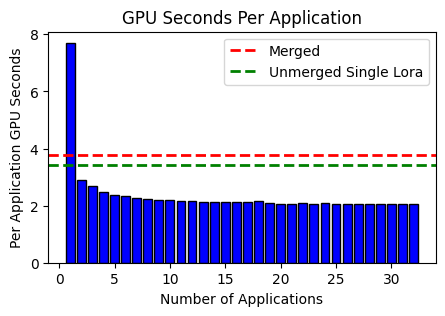

In [8]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re
from collections import defaultdict

# Function to calculate average latency from a list of latencies
def calculate_average_latency(file_path):
    latencies = []
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            latencies.append(result['latency'])
    return sum(latencies) / len(latencies) if latencies else float('nan')

# Directory containing the .jsonl files
directory = 'benchmark_result_pin_concurrency'  # change this to the actual folder path

# Dictionary to store the latencies
latencies = defaultdict(list)
unmerged_multi_lora = defaultdict(list)

# Read all .jsonl files and extract latencies
for file_path in glob(os.path.join(directory, '*.jsonl')):
    # Extract the approach name and concurrency value from the file name
    file_name = os.path.basename(file_path)

    parts = file_name.split('_')
    if parts[1] == 'unmerged' and 'multi' in parts:
        #print(parts)
        approach = '_'.join(parts[1:4])
        num_loras = int(parts[4])
        concurrency = int(parts[-1].replace('.jsonl', ''))
        avg_latency = calculate_average_latency(file_path)
        unmerged_multi_lora[num_loras].append(avg_latency)
    else:
        approach = parts[1]
    
        if 'unmerged_single_lora' in file_name:
            approach = 'unmerged_single_lora'
        if 'benchmark_merged' in file_name:
            approach = 'merged'
        concurrency = int(parts[-1].replace('.jsonl', ''))
        avg_latency = calculate_average_latency(file_path)
        print(f"approach {approach} avg_latency {avg_latency}")
        latencies[approach].append(avg_latency)

# Calculate average latencies for unmerged_multi_lora
avg_per_lora_gpu_seconds = {num_loras: (sum(latencies) / len(latencies)) / num_loras
                            for num_loras, latencies in unmerged_multi_lora.items()}

# Calculate average latencies for merged and unmerged_single_lora
avg_merged_latency = sum(latencies['merged']) / len(latencies['merged'])
avg_unmerged_single_lora_latency = sum(latencies['unmerged_single_lora']) / len(latencies['unmerged_single_lora'])

# Plot the bar plot
fig, ax = plt.subplots(figsize=(5, 3))
x = list(avg_per_lora_gpu_seconds.keys())
y = list(avg_per_lora_gpu_seconds.values())
ax.bar(x, y, color='blue', edgecolor='black')

# Add horizontal lines for merged and unmerged_single_lora
ax.axhline(y=avg_merged_latency, color='red', linestyle='--', linewidth=2, label='Merged')
ax.axhline(y=avg_unmerged_single_lora_latency, color='green', linestyle='--', linewidth=2, label='Unmerged Single Lora')

# Labels and title
ax.set_xlabel('Number of Applications')
ax.set_ylabel('Per Application GPU Seconds')
ax.set_title('GPU Seconds Per Application')
ax.legend()

plt.show()